# Required Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.metrics import cohen_kappa_score, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Load and Prepare Data

In [2]:
# available features in the data
features = ["customer_id", "medicine", "rating", "effectiveness", "side_effects", "condition", "benefits_review", 
            "side_effects_review", "overall_review"]

# loading the data: train and test
df_train = pd.read_csv("/Users/rajsingh/Downloads/Barclays/Data/train.tsv", sep="\t", names=features)
df_test = pd.read_csv("/Users/rajsingh/Downloads/Barclays/Data/test.tsv", sep="\t", names=features)

In [3]:
df_train.head(2)

,customer_id,medicine,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,overall_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."


In [4]:
df_test.head(2)

,customer_id,medicine,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,overall_review
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...


# Understanding Data

In [5]:
print("unique values count of train : " ,len(set(df_train['customer_id'].values)))
print("length of train : " ,df_train.shape[0])

print("unique values count of test : " ,len(set(df_test['customer_id'].values)))
print("length of test : " ,df_test.shape[0])

unique values count of train :  3107
length of train :  3107
unique values count of test :  1036
length of test :  1036


Text(0.5, 1.0, 'Top15 : The number of drugs per condition.')

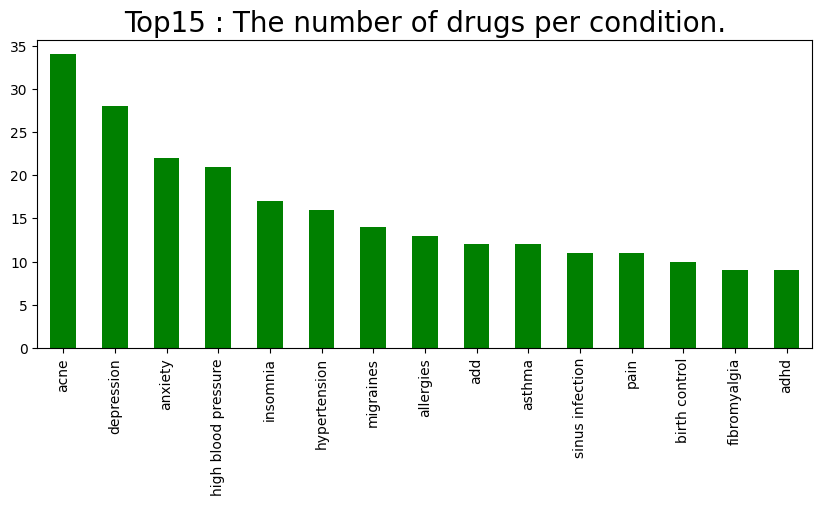

In [6]:
# number of drugs per condition in train data, top15

condition_dn = df_train.groupby(['condition'])['medicine'].nunique().sort_values(ascending=False)
condition_dn[0:15].plot(kind="bar", figsize = (10,4), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top15 : The number of drugs per condition.", fontsize = 20)

Text(0.5, 1.0, 'Bottom15 : The number of drugs per condition.')

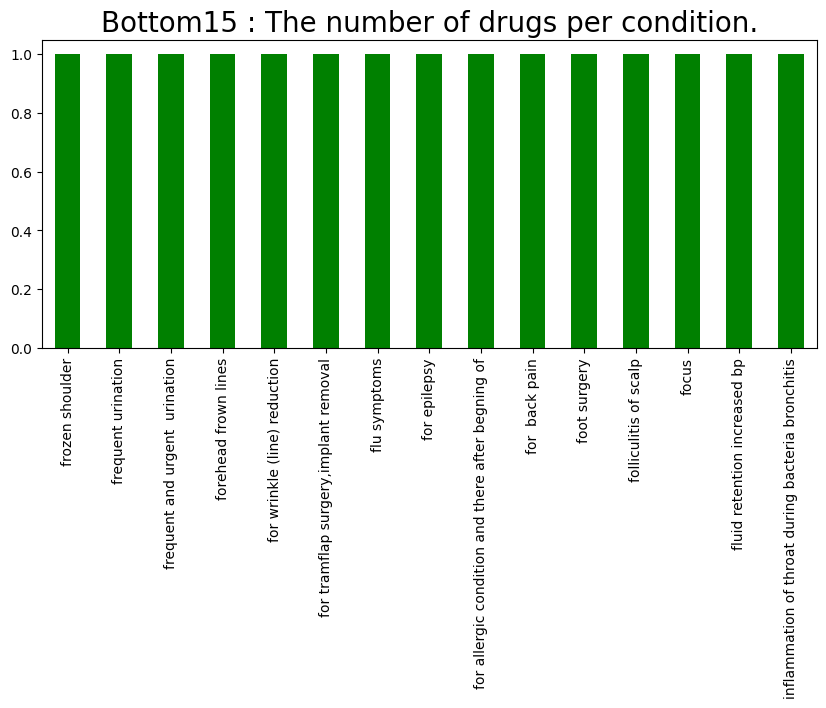

In [7]:
# number of drugs per condition in train data, bottom15

condition_dn = df_train.groupby(['condition'])['medicine'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-15:condition_dn.shape[0]].plot(kind="bar", figsize = (10,4), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom15 : The number of drugs per condition.", fontsize = 20)

Text(0.5, 1.0, 'Count of rating values')

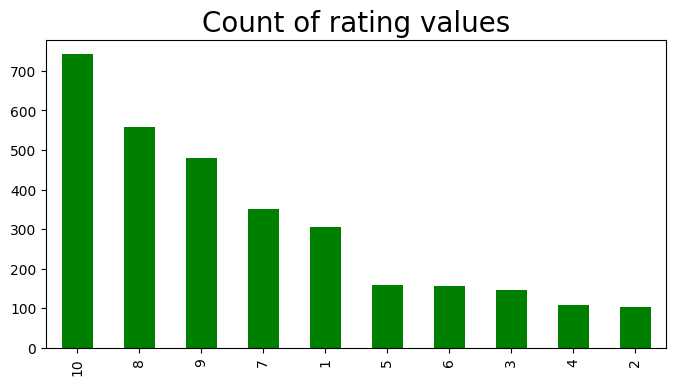

In [8]:
# count of rating values in train data

rating = df_train['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (8,4), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

In [9]:
# checking missing values in train and test

df_train.isnull().sum()

customer_id             0
medicine                0
rating                  0
effectiveness           0
side_effects            0
condition               1
benefits_review        18
side_effects_review    75
overall_review         12
dtype: int64

In [10]:
df_test.isnull().sum()

customer_id             0
medicine                0
rating                  0
effectiveness           0
side_effects            0
condition               0
benefits_review         5
side_effects_review    23
overall_review          1
dtype: int64

# Processing Data for Model

In [11]:
# combining all review-related text into one field to have better semantic understanding and also, 
# customer reviews is split across multiple text columns

for df in [df_train, df_test]:
    df["full_review"] = (df["benefits_review"].fillna("") + " " + df["side_effects_review"].fillna("") + " " + 
                         df["overall_review"].fillna(""))

In [12]:
df_train.head(1)

,customer_id,medicine,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,overall_review,full_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",slowed the progression of left ventricular dys...


In [13]:
df_test.head(1)

,customer_id,medicine,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,overall_review,full_review
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...,The antibiotic may have destroyed bacteria cau...


In [14]:
# we will be using sentence-bert to create embeddings

# loading a light pretrained Sentence-BERT model
embedder = SentenceTransformer("all-mpnet-base-v2")

In [15]:
# convert full review text into embeddings, each review becomes a 768-dimensional vector

X_train_emb = embedder.encode(df_train["full_review"].tolist(), batch_size=64, show_progress_bar=True)

X_test_emb = embedder.encode(df_test["full_review"].tolist(), batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [16]:
# adding trained embeddings to the train dataframe

train_with_emb = df_train.copy()
train_with_emb["embedding"] = list(X_train_emb)

# 1. Customer Review Classifier (Positive or Negative)

In [17]:
# understanding unique rating values in data
df_train.rating.sort_values().unique(), df_test.rating.sort_values().unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [18]:
# Lets define a rating to get classify the reviews in 2 classes: Positive or Negative, below can be adjusted based on need
# - Rating >= 7 -> Positive review -> 1
# - Rating < 7 -> Negative review -> 0

df_train["sentiment"] = (df_train["rating"] >= 7).astype(int)
df_test["sentiment"] = (df_test["rating"] >= 7).astype(int)

In [19]:
df_train.head(1)

,customer_id,medicine,rating,effectiveness,side_effects,condition,benefits_review,side_effects_review,overall_review,full_review,sentiment
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",slowed the progression of left ventricular dys...,0


In [20]:
df_train.sentiment.value_counts(), df_test.sentiment.value_counts()

(sentiment
 1    2130
 0     977
 Name: count, dtype: int64,
 sentiment
 1    670
 0    366
 Name: count, dtype: int64)

In [21]:
# since the classe are unbalanced, we will use scale_pos_weight parameter in xgboost to handle it

neg = (df_train["sentiment"] == 0).sum()
pos = (df_train["sentiment"] == 1).sum()
scale_pos_weight = round(float(neg / pos),4)
scale_pos_weight

0.4587

In [22]:
# training XGBoost classifier model for task
sentiment_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=300, max_depth=6, 
                                    eta=0.05, subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", 
                                    scale_pos_weight=scale_pos_weight, random_state=42)

# train the classifier
sentiment_model.fit(X_train_emb, df_train["sentiment"])

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [23]:
# predict sentiment on test data
sentiment_preds = sentiment_model.predict(X_test_emb)

probs = sentiment_model.predict_proba(X_test_emb)[:, 1]

# predict probabilities (required for ROC-AUC)
sentiment_probs = sentiment_model.predict_proba(X_test_emb)[:, 1]

# binary predictions
sentiment_preds = sentiment_model.predict(X_test_emb)

# ROC-AUC score
roc_auc = roc_auc_score(df_test["sentiment"], sentiment_probs)

# F1 score for NEGATIVE class (important for pharma)
f1_negative = f1_score(df_test["sentiment"], sentiment_preds, pos_label=0)

print(f"Sentiment ROC-AUC: {roc_auc:.3f}")
print(f"Negative-class F1-score: {f1_negative:.3f}")

Sentiment ROC-AUC: 0.823
Negative-class F1-score: 0.636


In [24]:
# the ROC-AUC score if 0.823 means model has good descriminative ability.

In [25]:
# adjusting threshold to get best 

probs = sentiment_model.predict_proba(X_test_emb)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1_neg = f1_score(df_test["sentiment"], preds, pos_label=0)
    f1_scores.append(f1_neg)

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_t:.2f}")
print(f"Best Negative-class F1: {best_f1:.3f}")

Best threshold: 0.70
Best Negative-class F1: 0.690


In [26]:
# With threshold as 0.7 our negative F1 score increases....
# meaning it classifies negative classes better at 0.7 threshold than at 0.5
# this also makes the model more conservative, reducing the risk of missing negative feedback.

# Effectiveness Rating Prediction 

In [27]:
# understanding unique rating values in data
df_train.effectiveness.unique(), df_test.effectiveness.unique()

(array(['Highly Effective', 'Marginally Effective', 'Ineffective',
        'Considerably Effective', 'Moderately Effective'], dtype=object),
 array(['Considerably Effective', 'Highly Effective',
        'Moderately Effective', 'Marginally Effective', 'Ineffective'],
       dtype=object))

In [28]:
# we will rate effectiveness in 5 classes

# converting categorical effectiveness ratings into numeric labels
label_encoder = LabelEncoder()

y_train_eff = label_encoder.fit_transform(df_train["effectiveness"])
y_test_eff = label_encoder.transform(df_test["effectiveness"])

In [30]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(mapping)

{'Considerably Effective': np.int64(0), 'Highly Effective': np.int64(1), 'Ineffective': np.int64(2), 'Marginally Effective': np.int64(3), 'Moderately Effective': np.int64(4)}


In [ ]:
# train a multiclass XGBoost model to get effectiveness rating

effectiveness_model = xgb.XGBClassifier(objective="multi:softprob", num_class=len(np.unique(y_train_eff)), n_estimators=400, 
                                        max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, eval_metric="mlogloss", 
                                        random_state=42)

effectiveness_model.fit(X_train_emb, y_train_eff)

In [ ]:
# predictions on test data
eff_preds = effectiveness_model.predict(X_test_emb)

# evaluation metrics calculation
kapa_score = cohen_kappa_score(y_test_eff, eff_preds, weights="quadratic")
mae = mean_absolute_error(y_test_eff, eff_preds)

print(f"Effectiveness kappa score: {kapa_score:.3f}")
print(f"Effectiveness MAE: {mae:.3f}")

In [ ]:
# kappa score = 0.108
# mae = 0.986
# On average, predictions are off by one level on the 5-point effectiveness scale.
# While agreement is weak, the model generally predicts within one level, making it useful as a supporting factor 
# rather than a standalone decision

# Customer Cohort Identification

In [ ]:
# clustering customers on Sentence-BERT embeddings and ratings

# kmeans = KMeans(n_clusters=5, random_state=42)
# df_train["customer_cluster"] = kmeans.fit_predict(X_train_emb)

# stack embeddings
X_emb = np.vstack(train_with_emb["embedding"].values)

# use rating
ratings = train_with_emb[["rating"]].values

# normalize rating
scaler = StandardScaler()
ratings_scaled = scaler.fit_transform(ratings)

# Combine embeddings + rating
X_emb_rating = np.hstack([X_emb, ratings_scaled])

# training kmeans clustering algo
kmeans_hybrid = KMeans(n_clusters=5, random_state=42)
train_with_emb["hybrid_cluster"] = kmeans_hybrid.fit_predict(X_emb_rating)

# Evaluate
sil_hybrid = silhouette_score(X_emb_rating, train_with_emb["hybrid_cluster"])
print(f"Cohorting Silhouette Score: {sil_hybrid:.3f}")

In [ ]:
# silhouette score of 0.115 indicates modest but meaningful separation. 
# This is expected in textual data and it is sufficient for exploratory insights and targeted interventions.”

# Medicine Recommendation Based on User Symptoms and Past Reviews

In [ ]:
# below method uses already created embeddings, models for recommendations 

def recommend_medicine(condition, top_n=5):

    # filter data from train for input condition
    condition_data = train_with_emb[train_with_emb["condition"].str.contains(condition, case=False, na=False)]

    # in case filter has no available data
    if condition_data.empty:
        return "No sufficient data available."

    # embedding the input condition for similarity search
    condition_embedding = embedder.encode([condition])

    # creating a single averaged review for each medicine....
    # this can be used in generalized way to represent customer feedback on each medicine
    medicine_profiles = (condition_data.groupby("medicine")["embedding"].apply(lambda x: np.mean(np.vstack(x), axis=0)))

    # calculate the similarity between input conditions and each medicine
    # basically checking if input condition is similar to averaged medicine review
    similarity_scores = [cosine_similarity(condition_embedding, emb.reshape(1, -1))[0][0] for emb in medicine_profiles.values]

    # predict sentiment & effectiveness for each medicine
    medicine_embeddings = np.vstack(medicine_profiles.values)
    sentiment_scores = sentiment_model.predict_proba(medicine_embeddings)[:, 1]
    effectiveness_scores = effectiveness_model.predict(medicine_embeddings)

    # calculate review count per medicine
    review_counts = (condition_data.groupby("medicine").size().reindex(medicine_profiles.index).values)

    # combine everything into a single DataFrame
    model_results = pd.DataFrame({"medicine": medicine_profiles.index, "semantic_similarity": similarity_scores, 
                            "sentiment_score": sentiment_scores, "effectiveness_score": effectiveness_scores, 
                            "review_count": review_counts})

    # calculate final explainable score
    model_results["final_score"] = (0.3 * model_results["semantic_similarity"] + 0.3 * model_results["sentiment_score"] + 
                              0.2 * (model_results["effectiveness_score"] / model_results["effectiveness_score"].max()) + 
                              0.2 * np.log1p(model_results["review_count"]))

    # returning top-N medicines...we kept 5 as 
    return model_results.sort_values("final_score", ascending=False).head(top_n)

In [ ]:
recommend_medicine("flu")